#### Face Identity Classification
This example illustrates Model Inversion (MINV) attacks on a face identity classfier model. The classfier is trained on [Large-scale CelebA - Aligned&Cropped](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. Please ensure the following structure in the data folder:

directory_structure:

```
data/
    ├── private/          # Private dataset
    │   ├── identity_1/
    │   │   ├── instance_1.jpg
    │   │   ├── instance_2.jpg
    │   │   └── ...
    │   ├── identity_2/
    │   │   ├── instance_1.jpg
    │   │   ├── instance_2.jpg
    │   │   └── ...
    │   └── ...
    └── public/           # Public dataset
        ├── identity_1/
        │   ├── instance_1.jpg
        │   ├── instance_2.jpg
        │   └── ...
        ├── identity_2/
        │   ├── instance_1.jpg
        │   ├── instance_2.jpg
        │   └── ...
        └── ...      
```


To prepare data for this example:

1. Download CelebA images "img_align_celeba.zip" from this [URL](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ) 
2. Download CelebA identities "identity_CelebA.txt" from this [URL](https://drive.google.com/drive/folders/0B7EVK8r0v71pOC0wOVZlQnFfaGs?resourcekey=0-pEjrQoTrlbjZJO2UL8K_WQ)
3. Unzip "img_align_celeba.zip" and place /img_align_celeba folder in examples/minv/celebA/data/
4. Place "identity_CelebA.txt" in examples/minv/celebA/data/
5. In the cell below select n classes to use, and n_private classes as private, n - n_private will be public.
6. Run the cell below

After running this, img_align_celebA folder can be removed if desired.

In [1]:
# Description: This script partitions the CelebA dataset into public and private folders based on the identity of the person in the image.

import pandas as pd
import os
import shutil

# read img_align_celeba/identity_CelebA.txt
df = pd.read_csv('./data/identity_CelebA.txt', sep=' ', header=None)
df.columns = ['img', 'label']

# Parameters
n = 1000 # total number of classes to take, max 10177
n_private = 500 # number of classes to be private, max 10177 and <= n. The rest will be public

# Create folders
os.makedirs('./data', exist_ok=True)
os.makedirs('./data/private', exist_ok=True)
os.makedirs('./data/public', exist_ok=True)

# Copy images to folders based on label
for i in range(1,n+1):
    if i <= n_private:
        os.makedirs('./data/private/' + str(i), exist_ok=True)
        for img in df[df['label'] == i]['img']:
            shutil.copy('./data/img_align_celeba/' + img, './data/private/' + str(i) + '/' + img)
    else:
        os.makedirs('./data/public/' + str(i), exist_ok=True)
        for img in df[df['label'] == i]['img']:
            shutil.copy('./data/img_align_celeba/' + img, './data/public/' + str(i) + '/' + img)
    if i % 100 == 0:
        print(i / n * 100, 'percent copied')

10.0 percent copied
20.0 percent copied
30.0 percent copied
40.0 percent copied
50.0 percent copied
60.0 percent copied
70.0 percent copied
80.0 percent copied
90.0 percent copied
100.0 percent copied


# Train the target model

In [2]:
import os
import sys
import yaml

# Path to the dataset zip file
data_folder = "./data"

# Path to your project root
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it

In [3]:
import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import  DataLoader, Subset, Dataset
from celebA_plgmi_handler import CelebA_InputHandler
import numpy as np

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
batch_size = train_config["train"]["batch_size"]
data_dir =  train_config["data"]["data_dir"] + "/celebA_private_data.pkl"

if not os.path.exists(data_dir):
    population_dataset = CelebA_InputHandler.UserDataset.from_celebA(config=train_config, subfolder='private')
    with open(data_dir, "wb") as file:
        pickle.dump(population_dataset, file)
        print(f"Save data to {data_dir}")
else:
    with open(data_dir, "rb") as file:
        population_dataset = pickle.load(file)
        print(f"Load data from {data_dir}")

dataset_size = len(population_dataset)
train_size = int(train_fraction * dataset_size)
test_size = int(test_fraction * dataset_size)

# Use sklearn's train_test_split to split into train and test indices
selected_index = np.random.choice(np.arange(dataset_size), train_size + test_size, replace=False)
train_indices, test_indices = train_test_split(selected_index, test_size=test_size)

train_subset = Subset(population_dataset, train_indices)
test_subset = Subset(population_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size =batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size= batch_size, shuffle=False)

num_classes = train_loader.dataset.dataset.get_classes()

/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Load data from ./data/celebA_private_data.pkl


Run this cell if you want to train the model, otherwise skip this and load it in cell below public loader

In [4]:
from torch import save, optim, nn
from celebA_plgmi_handler import CelebA_InputHandler
from target_model_class import ResNet18



num_classes = train_loader.dataset.dataset.get_classes()

# Create instance of target model
model = ResNet18(num_classes = num_classes)

# Read out the relevant parameters for training
lr = train_config["train"]["learning_rate"]
momentum = train_config["train"]["momentum"]
epochs = train_config["train"]["epochs"]
    
# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# train target model
train_result = CelebA_InputHandler().train(dataloader=train_loader,
                            model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            epochs=epochs)

# Evaluate on test set
test_result = CelebA_InputHandler().eval(test_loader, model, criterion)

/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/3:   7%|▋         | 11/154 [00:00<00:04, 31.34it/s]

Epoch 3/3: 100%|██████████| 154/154 [00:01<00:00, 124.18it/s]


In [5]:
# Create metadata to be used by LeakPro
from leakpro import LeakPro
import os

# Ensure the directory exists
log_dir = train_config["run"]["log_dir"]
target_model_path = os.path.join(log_dir, "target_model.pkl")
os.makedirs(os.path.dirname(target_model_path), exist_ok=True)  # Create the directory if it doesn't exist

# Store the model and metadata
model = train_result.model
model.to("cpu")
with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)
    
dataset_name = train_config["data"]["dataset"]
meta_data = LeakPro.make_mia_metadata(train_result = train_result,
                                      optimizer = optimizer,
                                      loss_fn = criterion,
                                      dataloader = train_loader,
                                      test_result = test_result,
                                      epochs = epochs,
                                      train_indices = train_indices,
                                      test_indices = test_indices,
                                      dataset_name = dataset_name)

with open("target/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)

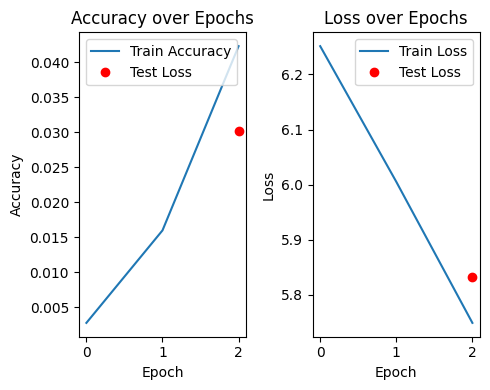

In [6]:
import matplotlib.pyplot as plt

train_acc = train_result.metrics.extra["accuracy_history"]
train_loss = train_result.metrics.extra["loss_history"]
test_acc = test_result.accuracy
test_loss = test_result.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Public loader
from examples.minv.celebA.utils.celebA_data import get_celebA_publicloader

pub_loader = get_celebA_publicloader(train_config)


Load data from ./data/celebA_public_data.pkl


In [8]:
import torch
from torch.nn import functional as F
import numpy as np
from target_model_class import ResNet18

# We have model_metadata.pkl and target_model.pkl. Load metadata and target model
# Load the model
num_classes = train_loader.dataset.dataset.get_classes()
model = ResNet18(num_classes=num_classes)
model.load_state_dict(torch.load('./target/target_model.pkl'))
model.eval()


/tmp/ipykernel_913764/2582084071.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./target/target_model.pkl'))


ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Remove dis.pth and gen.pth if you want LeakPro to enter training loop. Number of iterations set to n_iter = 10 in this example.

Currently, result class is not setup.

In [9]:
from leakpro import LeakPro
from celebA_plgmi_handler import CelebA_InputHandler
config_path = "audit.yaml"


# Initialize the LeakPro object
leakpro = LeakPro(CelebA_InputHandler, config_path)

# Run the audit
results = leakpro.run_audit(return_results=True)


2025-04-03 19:37:05,210 INFO     Target model blueprint created from ResNet18 in ./target_model_class.py.
2025-04-03 19:37:05,216 INFO     Loaded target model metadata from ./target/model_metadata.pkl
/home/fazeleh/LeakPro/leakpro/input_handler/minv_handler.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case w

Generate some sample images

In [ ]:
from examples.minv.celebA.utils.generator import ResNetGenerator
import torch
import matplotlib.pyplot as plt
import numpy as np

"""Generate example images using the trained generator"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# read config file
with open('audit.yaml', 'r') as file:
    config = yaml.safe_load(file)
    

dim_z = config['audit']['attack_list']['plgmi']['dim_z']

# Load generator and discriminator
gen = ResNetGenerator(num_classes=num_classes, dim_z=dim_z).to(device)
gen.load_state_dict(torch.load('gen.pth'))

# Generate images
gen.eval()

n_images = 4
z = torch.empty(n_images, dim_z, dtype=torch.float32, device=device).normal_()
y = torch.randint(0, num_classes, (n_images,)).to(device) # random labels
#y = torch.tensor([0, 1, 2, 3]).to(device) # fixed labels
print(y) 

with torch.no_grad():
    fake = gen(z, y)

# Normalize the generated images to the range [0, 1]
fake = (fake - fake.min()) / (fake.max() - fake.min())

# Plot the generated images
plt.figure(figsize=(10, 5))
for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(np.transpose(fake[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Printed tensor corresponds to the reconstructed identity in private dataset